# Deteksi Katarak Menggunakan CNN pada Citra Mata

## Ringkasan dan Permasalahan Project

### Ringkasan:
Proyek ini bertujuan untuk mendeteksi katarak pada citra mata menggunakan Convolutional Neural Network (CNN). Dengan menggunakan dataset gambar mata yang terbagi menjadi dua kelas (normal dan katarak), model ini akan belajar membedakan antara gambar mata normal dan gambar mata yang terkena katarak.

### Permasalahan:
Katarak adalah penyakit mata yang umum yang menyebabkan penurunan penglihatan. Deteksi dini katarak sangat penting untuk mencegah kerusakan lebih lanjut pada mata. Proyek ini bertujuan untuk mengembangkan model yang dapat mendeteksi katarak secara otomatis dari gambar mata.

### Tujuan yang akan dicapai:
- Mengembangkan model CNN untuk mendeteksi katarak pada citra mata.
- Mengevaluasi performa model menggunakan metrik seperti akurasi dan loss.
- Meningkatkan akurasi model dengan augmentasi data dan teknik regularisasi.

### Model / Alur Penyelesaian:
![Alur Penyelesaian](./activityml.png)
## Penjelasan Dataset, EDA dan Proses Features Dataset

### Penjelasan Dataset:
Dataset terdiri dari dua kelas: normal dan katarak. Setiap kelas berisi gambar mata yang diambil dalam kondisi yang berbeda. Dataset ini dibagi menjadi set pelatihan dan set pengujian.

### EDA (Exploratory Data Analysis):
- Menghitung jumlah gambar dalam setiap kelas.
- Menampilkan contoh gambar dari setiap kelas.
- Membuat scatter plot untuk ukuran gambar.

### Proses Features Dataset:
- Normalisasi gambar.
- Augmentasi data untuk meningkatkan keragaman dataset.



### Proses Learning / Modeling:
- Menggunakan CNN untuk memproses gambar.
- Model terdiri dari beberapa lapisan konvolusi, pooling, batch normalization, dan dropout.
- Melatih model dengan menggunakan ImageDataGenerator untuk augmentasi data.

## Performa Model

### Performa Model:
- Evaluasi model menggunakan set pengujian.
- Metrik yang digunakan: akurasi, loss, dan lain-lain.
- Plot hasil pelatihan dan validasi.

## Diskusi Hasil dan Kesimpulan

### Diskusi Hasil dan Kesimpulan:
- Diskusikan hasil evaluasi model.
- Kesimpulan dari hasil yang diperoleh.
- Rekomendasi untuk penelitian lebih lanjut.


In [43]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Baca Dataset**




In [44]:
# Path ke folder dataset
my_data_dir = '/content/drive/My Drive/Deteksi_Katarak/deteksi/'  # Ganti dengan path dataset Anda
train_path = os.path.join(my_data_dir, 'train')
test_path = os.path.join(my_data_dir, 'test')

plant_types = ["normal", "cataract"]

In [45]:
# EDA (Exploratory Data Analysis)
def count_images_in_directory(path, plant_types):
    total_images = 0
    for plant_type in plant_types:
        file_list = os.listdir(os.path.join(path, plant_type))
        print(f"Number of {plant_type} images:", len(file_list))
        total_images += len(file_list)
    print("Total images:", total_images)

count_images_in_directory(train_path, plant_types)
count_images_in_directory(test_path, plant_types)


Number of normal images: 246
Number of cataract images: 245
Total images: 491
Number of normal images: 52
Number of cataract images: 44
Total images: 96


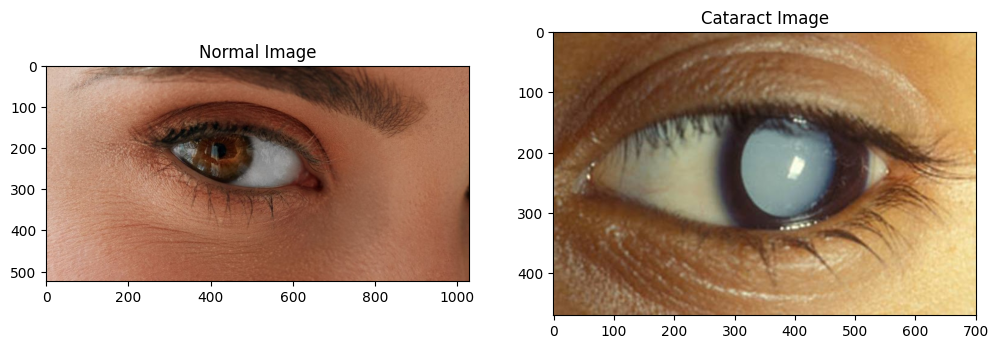

Normal image shape: (524, 1029, 3)
Cataract image shape: (470, 701, 3)


In [46]:
#memuat gambar dan menampilkannya
path1 = os.path.join(train_path, 'normal', 'image_50.png')
path2 = os.path.join(train_path, 'cataract', 'image_23.png')

normal_img = imread(path1)
cataract_img = imread(path2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Normal Image")
plt.imshow(normal_img)
plt.subplot(1, 2, 2)
plt.title("Cataract Image")
plt.imshow(cataract_img)
plt.show()

print("Normal image shape:", normal_img.shape)
print("Cataract image shape:", cataract_img.shape)


Mean dimensions for normal: (406.5081300813008, 594.1422764227642)
Mean dimensions for cataract: (606.1183673469387, 925.3591836734694)


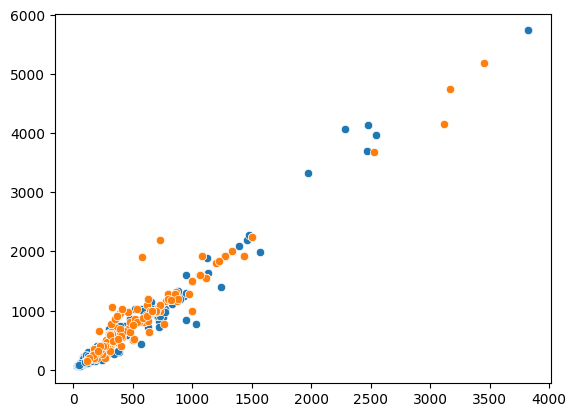

In [47]:
#  Scatter plot ukuran gambar
def plot_image_sizes(path, plant_type):
    x, y = [], []
    for image in os.listdir(os.path.join(path, plant_type)):
        img = imread(os.path.join(path, plant_type, image))
        d1, d2, colors = img.shape
        x.append(d1)
        y.append(d2)
    sns.scatterplot(x=x, y=y)
    print(f"Mean dimensions for {plant_type}: ({np.mean(x)}, {np.mean(y)})")

plot_image_sizes(train_path, 'normal')
plot_image_sizes(train_path, 'cataract')


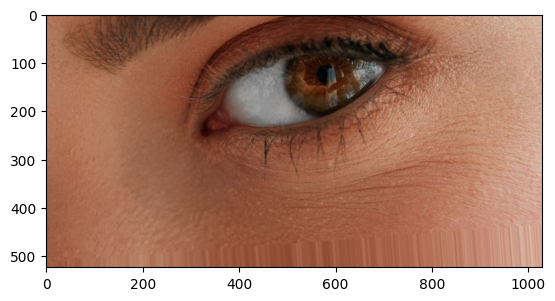

In [48]:
# Setup ImageDataGenerator
image_shape = (500, 800, 3)
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               rescale=1./255)  # Normalisasi

plt.imshow(image_gen.random_transform(normal_img))
plt.show()

In [49]:
# Membuat generator untuk train dan test
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False)


Found 491 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [50]:
# Definisi model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 498, 798, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 249, 399, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 249, 399, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 249, 399, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 247, 397, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 198, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 123, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 123, 198, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 121, 196, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 60, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 188160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     6,021,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,035,969 (23.03 MB)

 Trainable params: 6,035,745 (23.02 MB)

 Non-trainable params: 224 (896.00 B)

In [51]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [52]:
# Training model
results = model.fit(train_image_gen, epochs=30,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.6600 - loss: 0.8168 - val_accuracy: 0.4583 - val_loss: 1.2297
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.7933 - loss: 0.4594 - val_accuracy: 0.4583 - val_loss: 1.1609
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.8390 - loss: 0.3988 - val_accuracy: 0.4583 - val_loss: 1.0290
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.8477 - loss: 0.3565 - val_accuracy: 0.4583 - val_loss: 0.8382
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.8452 - loss: 0.3370 - val_accuracy: 0.4583 - val_loss: 0.9185
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.8870 - loss: 0.3030 - val_accuracy: 0.4583 - val_loss: 0.8523
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.8552 - loss: 0.3307 - val_accuracy: 0.5208 - val_loss: 0.6959
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.9005 - loss: 0.2647 - val_accuracy: 0.4688 - val_loss

##Callbacks

### EarlyStopping dan ModelCheckpoint untuk menghentikan pelatihan lebih awal jika model tidak membaik dan untuk menyimpan model terbaik.



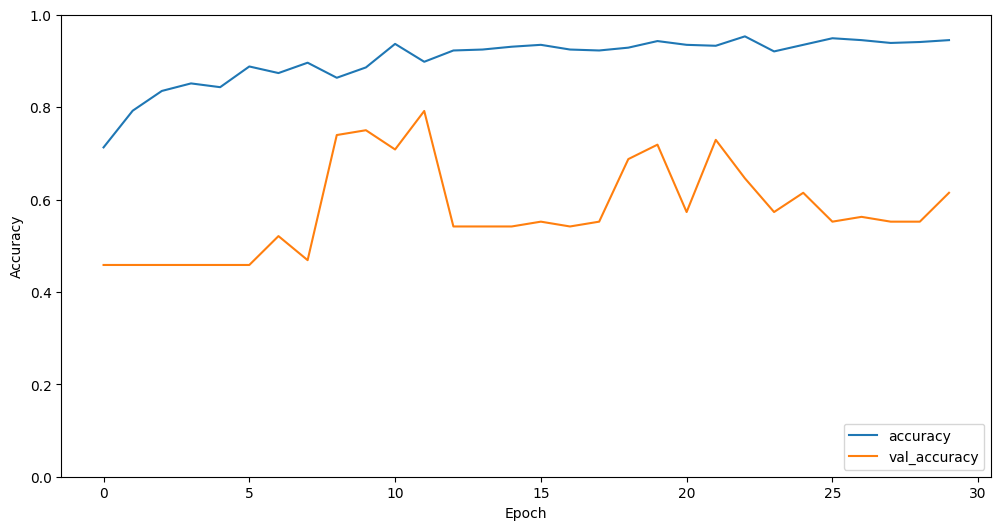

In [53]:
# Plotting training results
plt.figure(figsize=(12, 6))
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [54]:
# Import Libraries untuk Prediksi
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [55]:
# Fungsi untuk Memuat dan Memproses Gambar
def load_and_preprocess_image(img_path, target_size=(500, 800)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array = img_array / 255.0  # Normalisasi
    return img_array

In [56]:
# Memuat Gambar untuk Dites
img_path = '/content/drive/My Drive/Deteksi_Katarak/deteksi/normal.webp'
processed_img = load_and_preprocess_image(img_path)

In [57]:
# Melakukan Prediksi dengan Model
prediction = model.predict(processed_img)
prediction_class = (prediction > 0.5).astype("int32")[0][0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


Prediksi: Normal


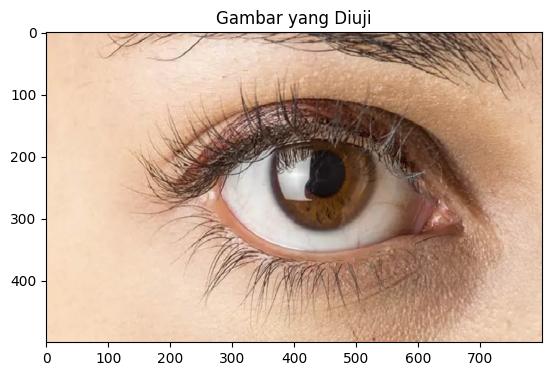

In [58]:
#  Menampilkan Hasil Prediksi
if prediction_class == 0:
    print("Prediksi: Cataract")
else:
    print("Prediksi: Normal")

# Tampilkan Gambar yang Diuji
plt.imshow(image.load_img(img_path, target_size=(500, 800)))
plt.title("Gambar yang Diuji")
plt.show()